$$
\large \textbf{Problema 05
}
$$

El agua de un lago de zonas templadas, al igual que el líquido en un reactor de procesos químicos, está térmicamente estratificada. Cerca de la superficie el agua es tibia y liviana (epilimnion) y en el fondo más fría y densa (hipolimnion). Ambas capas están separadas, aproximadamente, por un plano conocido por thermocline, donde la derivada segunda de la temperatura respecto de la profundidad se hace cero (o la derivada primera tiene su máximo). A esta profundidad el flujo de calor de la superficie al fondo de la capa se puede calcular con la ley de Fourier:

$$
J=-k\:\frac{dT}{dx}
$$

Dados los datos de la tabla siguiente, correspondientes a la temperatura del líquido de un reactor en función de la profundidad, realice un ajuste de la temperatura y de su derivada en función de la profundidad usando el método de splines. Encuentre la posición aproximada de la thermocline y calcule el flujo de calor a través de la interfaz (tome $k=0.01\:\frac{cal}{s\:cm\:°C}$)

$$
\begin{matrix}
z\:(m) & | & 0 & 0.5 & 1.0 & 1.5 & 2.0 & 2.5 & 3.0\\
T\:(°C) & | & 70 & 68 & 55 & 22 & 13 & 11 & 10
\end{matrix}
$$

***

In [1]:
import numpy as np                # Librería de álgebra lineal
import matplotlib.pyplot as plt   # Librería de gráficos
plt.rc('figure', figsize=(9,6))
plt.rc('font', size=14)

### Datos

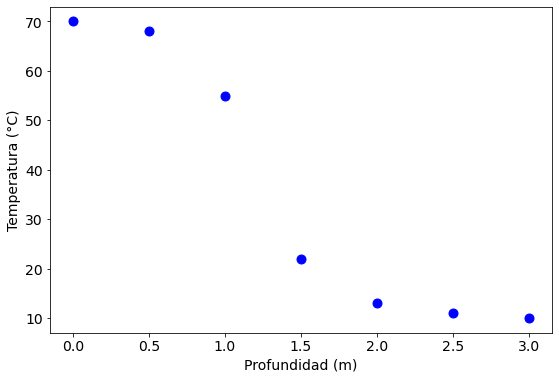

In [2]:
z = [0, 0.5, 1, 1.5, 2, 2.5, 3]
T = [70, 68, 55, 22, 13, 11, 10]

plt.plot(z,T, "o", color='b', ms=9)
plt.xlabel('Profundidad (m)')
plt.ylabel('Temperatura (°C)')
plt.show()

### Algoritmo de Thomas

In [3]:
#  a = subdiagonal inferior
#  b = diagonal principal
#  c = subdiagonal superior
#  d = vector de carga

def Thomas(a, b, c, d):
    N = len(d)
    a = [0] + a
    c = c + [0]
    
    C = [c[0]/b[0]]
    D = [d[0]/b[0]]
    
    for i in range(1,N):
        C.append(c[i]/(b[i]-c[i-1]*a[i]))
        D.append((d[i]-D[i-1]*a[i])/(b[i]-c[i-1]*a[i]))
    
    X = np.zeros(N)
    X[N-1] = D[N-1]
    for i in range(N-2,0,-1):
        X[i] = D[i]-C[i]*X[i+1]
    return X

### Función Spline

In [4]:
# x = abcisas de los puntos a interpolar
# y = ordenadas de los puntos a interpolar
# n = tipo de condiciones a utilizar:
#       Curvaturas fijas:   n = 1
#       Bordes sujetos:     n = 2
# c = condiciones:
#       Curvaturas fijas:   vector de 2 componentes con la derivada segunda en el primer y último punto
#       Bordes sujetos:     vector de 2 componentes con la derivada primera en el primer y último punto

def spline3(x, y, n, c):
    N = len(x)-1
    
    h = []
    d = []
    for i in range(N):
        h.append(x[i+1]-x[i])
    for i in range(N):
        d.append((y[i+1]-y[i])/h[i])
    
    A = []
    B = []
    C = []
    for i in range(N-2):
        A.append(h[i+1])
        C.append(h[i+1])
    for i in range(N-1):
        B.append(2*(h[i]+h[i+1]))
    
    if n==1:
        D = [6*(d[1]-d[0])-h[0]*c[0]]
        for i in range(1, N-2):
            D.append(d[i+1]-d[i])
        D.append(6*(d[-1]-d[-2])-h[-1]*c[1])
        S = Thomas(A,B,C,D)
        S = np.insert(S, 0, c[0])
        S = np.append(S, c[1])
    
    elif n==2:
        B[0] = 3/2*h[0]+2*h[1]
        B[-1] = 2*h[-2]+3/2*h[-1]
        D = [6*(d[1]-d[0])-3*(d[0]-c[0])]
        for i in range(1, N-2):
            D.append(6*(d[i+1]-d[i]))
        D.append(6*(d[-1]-d[-2])-3*(c[1]-d[-1]))
        S = Thomas(A,B,C,D)
        S = np.insert(S, 0, 3*(d[0]-c[0])/h[0]-S[0]/2)
        S = np.append(S, 3*(c[1]-d[-1])/h[-1]-S[-1]/2)
    
    P1 = []
    P2 = []
    P3 = []
    P4 = []
    for i in range(N):
        P1.append((S[i+1]-S[i])/(6*h[i]))
        P2.append(S[i]/2)
        P3.append(d[i]-h[i]*(2*S[i]+S[i+1])/6)
        P4.append(y[i])
    P = [P1, P2, P3, P4]
    return P

### Interpolación

In [5]:
n = 1   # Cond. de bordes sujetos
c = [0, 0]
P = np.array(spline3(z, T, n, c))
print(P)

[[  0.          -4.11253814  13.83975498 -10.43914242   3.01318895
   -2.30126336]
 [  0.           0.          -6.16880721  14.59082525  -1.06788838
    3.45189504]
 [ -4.         -24.97186546 -66.37553514 -22.68562702  -4.21935305
   -3.15063168]
 [ 70.          68.          55.          22.          13.
   11.        ]]


In [6]:
# x = abcisas de los puntos interpolados
# y = ordenadas de los puntos interpolados
# P = debe ser la matriz de coeficientes obtenida por el spline3
# ppp = cantidad de puntos por parábola que se deseen graficar

def grspline3(x, y, P, ppp):
    plt.plot(x, y, 'o', color='blue')
    plt.xlabel('Profundidad (m)')
    plt.ylabel('Temperatura (°C)')
    
    N = len(x)-1
    Y = np.zeros([N, ppp])
    dY = np.zeros([N, ppp])
    XX = []
    
    for i in range(N):
        X = np.linspace(x[i], x[i+1], ppp)
        XX.append(X)
        for j in range(ppp):
            Y[i, j] = ((P[0, i]*(X[j]-x[i])+P[1, i])*(X[j]-x[i])+P[2, i])*(X[j]-x[i])+P[3, i]
            dY[i, j] = (3*P[0, i]*(X[j]-x[i])+2*P[1, i])*(X[j]-x[i])+P[2, i]
        plt.plot(X, Y[i, :], linestyle='-', color='c')
        plt.plot(X, dY[i, :], linestyle='-', color='g')
    
    return XX, Y, dY, plt.show()

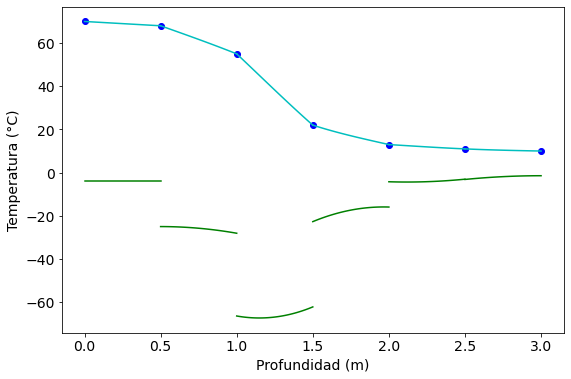

In [7]:
zSP3, TSP3, dTSP3, plot = grspline3(z, T, P, 100)

### Thermocline

In [8]:
posmin = dTSP3.argmin()
dT_min = np.hstack(dTSP3)[posmin]
z_min = np.hstack(zSP3)[posmin]
print('Thermocline:     ', z_min, ' m')
print('Flujo de calor: ', dT_min, '  cal/(m^2 s)')

Thermocline:      1.1464646464646464  m
Flujo de calor:  -67.2918926578044   cal/(m^2 s)
